In [396]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="whitegrid")
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

In [397]:
def get_players_by_letter(l):
    url = f"https://www.basketball-reference.com/players/{l.lower()}/"
    r = requests.get(url)

    soup = BeautifulSoup(r.text, "html.parser")
    table = soup.find("table", id="players")

    body = table.find("tbody")
    rows = body.find_all("tr")

    columns = []
    heading = table.find("thead")
    heading_row = heading.find("tr")
    for x in heading_row.find_all("th"):
        columns.append(x.string)

    data = []
    for row in rows:
        temp = []
        th = row.find("th")
        td = row.find_all("td")
        if th:
            temp.append(th.text)
        else:
            continue
        for v in td:
            temp.append(v.text)
        data.append(temp)
    
    return pd.DataFrame(data, columns=columns) 

In [398]:
players = []
for l in "abcdefghijklmnopqrstuvwyz": # No 'x'
    players.append(get_players_by_letter(l))

players = pd.concat(players)
#players.to_csv("all_players.csv", encoding="utf-8")

In [399]:
players["Wt"] = pd.to_numeric(players["Wt"])
players["Wt"] = players["Wt"] * 0.45359237

In [400]:
def to_meters(h):
    feet, inches = h.split("-")
    feet = int(feet) / 3.2808
    inches = int(inches) / 39.37
    
    return (feet + inches)

def rename_pos(pos):
    if pos == "C-F":
        return "F-C"
    elif pos == "F-G":
        return "G-F"
    else:
        return pos

In [401]:
players["Ht"] = players["Ht"].apply(to_meters)
players["Pos"] = players["Pos"].apply(rename_pos)

In [402]:
players.head(3)

,Player,From,To,Pos,Ht,Wt,Birth Date,Colleges
0,Alaa Abdelnaby,1991,1995,F-C,2.082823,108.862169,"June 24, 1968",Duke University
1,Zaid Abdul-Aziz,1969,1978,F-C,2.057423,106.594207,"April 7, 1946",Iowa State University
2,Kareem Abdul-Jabbar*,1970,1989,C,2.184426,102.058283,"April 16, 1947","University of California, Los Angeles"


In [419]:
players.shape

(4685, 9)

In [403]:
print(players.Pos.unique())
print(players.Wt.dtype)
print(players.Ht.dtype)

['F-C' 'C' 'G' 'F' 'G-F']
float64
float64


In [404]:
players.Ht.sort_values().unique()

array([1.60021868, 1.65101879, 1.67641884, 1.70181889, 1.72721894,
       1.75261899, 1.77801904, 1.80341909, 1.82882224, 1.85422229,
       1.87962234, 1.90502239, 1.93042244, 1.95582249, 1.98122254,
       2.00662259, 2.03202264, 2.0574227 , 2.08282275, 2.1082228 ,
       2.13362594, 2.159026  , 2.18442605, 2.2098261 , 2.23522615,
       2.2606262 , 2.28602625, 2.3114263 ])

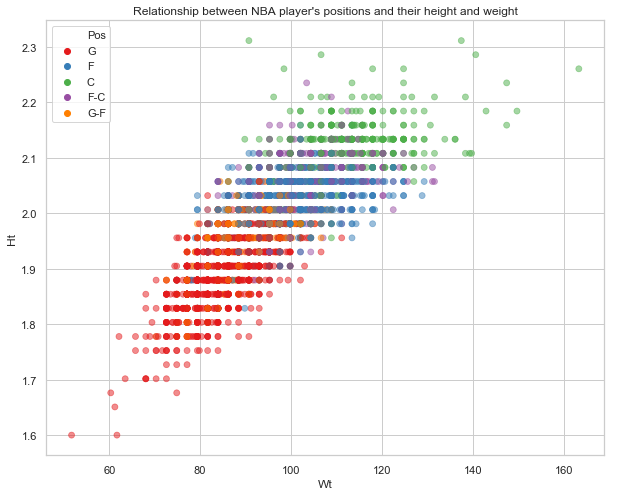

In [421]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(x="Wt", y="Ht", data=players, hue="Pos", hue_order=["G", "F", "C", "F-C", "G-F"], 
                     alpha=0.5, palette="Set1", edgecolor=None)
ax.set_title("Relationship between NBA player's positions and their height and weight")
plt.show()

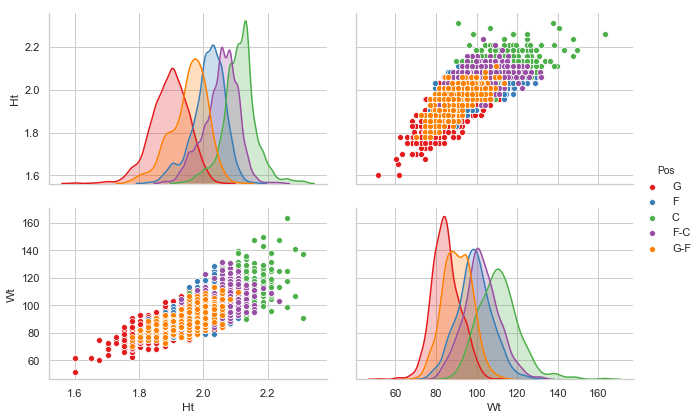

In [407]:
sns.pairplot(players[["Ht", "Wt", "Pos"]], hue="Pos", hue_order=["G", "F", "C", "F-C", "G-F"], 
             height=3, aspect=1.5, palette="Set1")
plt.show()

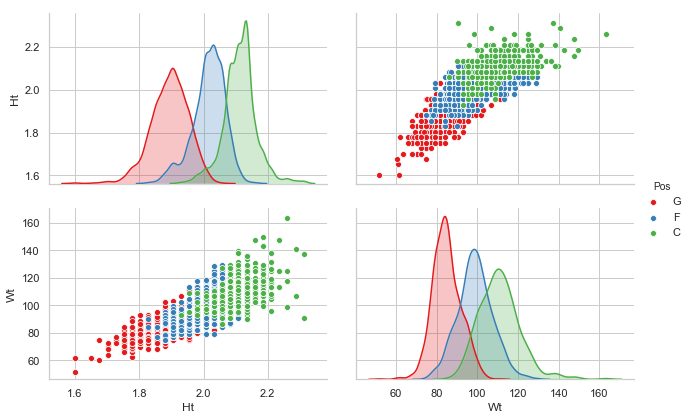

In [409]:
sns.pairplot(players[["Ht", "Wt", "Pos"]], hue="Pos", hue_order=["G", "F", "C"], 
             height=3, aspect=1.5, palette="Set1")
plt.show()

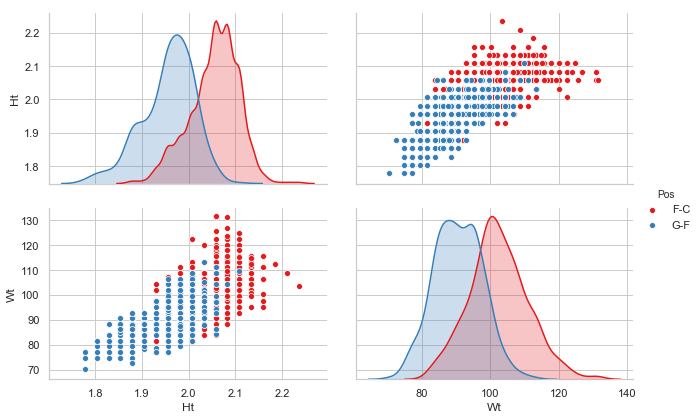

In [410]:
sns.pairplot(players[["Ht", "Wt", "Pos"]], hue="Pos", hue_order=["F-C","G-F"], 
             height=3, aspect=1.5, dropna=True, palette="Set1")
plt.show()

# KNN
## Divding by categories

Categories
* 0 - Center
* 1 - Forward
* 2 - Forward - Center 
* 3 - Guard
* 4 - Guard - Forward

In [411]:
players["Pos"] = pd.Categorical(players["Pos"])
print(players["Pos"].dtype)

category


In [412]:
players["Cat"] = players["Pos"].cat.codes

In [413]:
players.head(3)

,Player,From,To,Pos,Ht,Wt,Birth Date,Colleges,Cat
0,Alaa Abdelnaby,1991,1995,F-C,2.082823,108.862169,"June 24, 1968",Duke University,2
1,Zaid Abdul-Aziz,1969,1978,F-C,2.057423,106.594207,"April 7, 1946",Iowa State University,2
2,Kareem Abdul-Jabbar*,1970,1989,C,2.184426,102.058283,"April 16, 1947","University of California, Los Angeles",0


## Splitting, fitting, building classifier

In [414]:
players_noNaN = players.dropna()
X = players_noNaN.iloc[:, [4, 5]].values
y = players_noNaN.Cat.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

# Building the classifier
classifier = KNeighborsClassifier(n_neighbors=5, metric="minkowski", p=2)
classifier.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

## Predicting

In [415]:
y_pred = classifier.predict(X_test)
y_pred

array([2, 1, 3, ..., 3, 1, 0], dtype=int8)

## Confusion matrix

In [416]:
cm = confusion_matrix(y_test, y_pred, labels=[3, 1, 0, 4, 2]) # labels are G, F, C, G-F, and F-C in that order
cm

array([[347,  46,   1,  15,   0],
       [ 39, 212,  18,   7,  21],
       [  1,  30,  86,   0,  18],
       [ 89,  56,   0,  17,   0],
       [ 15,  73,  44,   2,  33]], dtype=int64)

In [417]:
y_test

array([1, 1, 3, ..., 1, 2, 0], dtype=int8)

## Visualizing
### Train set

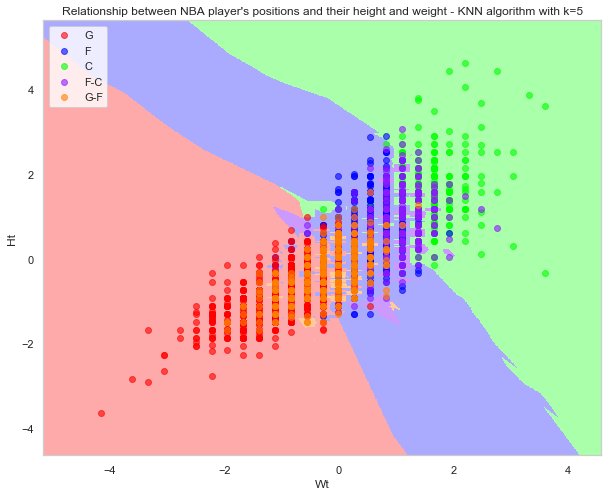

In [422]:
fig, ax = plt.subplots(figsize=(10,8))

X_set, y_set = X_train, y_train

cmap_light = ListedColormap(['#AAFFAA', '#AAAAFF', "#CC99FF", "#FFAAAA", "#ffcc99"])
cmap_bold = ListedColormap(['#00FF00', '#0000FF', "#8C1AFF", "#FF0000", "#ff8000"])


x_min, x_max = X_set[:, 0].min() - 1, X_set[:, 0].max() + 1
y_min, y_max = X_set[:, 1].min() - 1, X_set[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

#plt.figure()
ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

for i, j in enumerate(np.unique(y_set)):
    
    if j == 0:
        label = "C"
    elif j == 1:
        label = "F"
    elif j == 2:
        label = "F-C"
    elif j == 3:
        label = "G"
    elif j == 4:
        label = "G-F"
        
    ax.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], c=[cmap_bold(i)], label=label, alpha=0.6)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

ax.set_title("Relationship between NBA player's positions and their height and weight - KNN algorithm with k=5")
ax.set_xlabel("Wt")
ax.set_ylabel("Ht")

handles,labels = ax.get_legend_handles_labels()
handles = [handles[3], handles[1], handles[0], handles[2], handles[4]]
labels = [labels[3], labels[1], labels[0], labels[2], labels[4]]

ax.legend(handles, labels, loc=2)

plt.show()

## Predicting

In [423]:
def predict_pos(h, w):
    h_w = sc_X.transform([[h, w]]) 
    pred = classifier.predict_proba(h_w)
    print(f"Prob of being guard: {pred[0][3]}")
    print(f"Prob of being forward: {pred[0][1]}")
    print(f"Prob of being center: {pred[0][0]}")
    print(f"Prob of being guard-forward: {pred[0][4]}")
    print(f"Prob of being forward-center: {pred[0][2]}")

In [424]:
predict_pos(1.90, 85)

Prob of being guard: 0.8
Prob of being forward: 0.0
Prob of being center: 0.0
Prob of being guard-forward: 0.2
Prob of being forward-center: 0.0
